In [1]:
########## Block 1 ############## <-- Please refer this block number when you ask questions
import subprocess
# packages for scientific computing
import numpy as np
from scipy.interpolate import interp1d
# package for plotting
import matplotlib.pyplot as plt
%matplotlib inline
# Pythonic interface to the HDF5 binary data format
import h5py
# Package for Markov chain Monte Carlo
import emcee
import pyDOE
# scikit-learn: machine learning in Python
# https://scikit-learn.org/stable/tutorial/basic/tutorial.html
# In this example, we are using the principal component analysis 
# and the Gaussian process regression as implemented in sklearn.
# Detailed documentation of these modules:
# Principal component analysis (PCA): 
# https://scikit-learn.org/stable/modules/decomposition.html
# Gaussian process gressor (GPR)):
# https://scikit-learn.org/stable/modules/gaussian_process.html
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import \
     GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels

# suppression warning messages
import warnings
warnings.filterwarnings('ignore')

# some plot settings, not important
fontsize  = 12
plt.rcdefaults()
plt.rcParams.update({
    'font.size': fontsize,
    'legend.fontsize': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.formatter.limits': (-5, 5),
    'axes.spines.top': True,
    'axes.spines.right': True,
    'legend.frameon': False,
    'image.cmap': 'Blues',
    'image.interpolation': 'none',
})


In [24]:
########## Block 2 ##############
ParamLabels = ["p","w","k","d","R","a","b2","b3"]
ParamTexLabels = ["p","w","k","d","R","a","b2","b3"]
RangeWithLabels = {
                "p": [-0.1,0.1],
                "w": [0.5,1.0],
                "k": [0.3, 3.0],
                "d": [0,1.0],
                "R": [4.9, 5.2],
                "a": [0.4, 0.6],
                "b2": [0,.3],
                "b3": [0,.3]
                }
ranges = np.array([
        RangeWithLabels[l] for l in ParamLabels
])
ptp = ranges[:,1] - ranges[:,0]
ndim = len(ParamLabels)

# This function load a pre-generated Latin-hypercube
# design of parameters [p, w, sigma, v] 
def load_existing_design(filename="./Design-all.dat"):
    Design = np.loadtxt(filename).T
    return Design

# This function sample completely random design
# We will compare its difference with LHS design
def Random_design(npoints, ranges, seed=12345):
    Design = pyDOE.lhs(ndim, samples=npoints, criterion="maximin")
    Design = ranges[:,0] + Design*ptp
    with open("./Design-all.dat", 'w') as f:
        for row in Design:
            f.write(("{:1.4e}\t"*ndim+"\n").format(*row))
    return Design

In [10]:
########## Block 3 ##############
# Load existing design
nsamples = 512
#Random_design(nsamples, ranges)
Design = load_existing_design()
print(Design.shape)

# write jobs
fformat="""reduced-thickness={p}
fluctuation={k}
nucleon-width={w} 
nucleon-min-dist={d} 
WS-R0={R} 
WS-a0={a} 
WS-b2={b2} 
WS-b3={b3}
"""

for i, p in enumerate(Design.T):
    with open("inputs-all/{}".format(i),'w') as f:
        f.write(fformat.format(p=p[0],w=p[1],k=p[2],d=p[3],R=p[4],a=p[5],b2=p[6],b3=p[7]))

(8, 512)


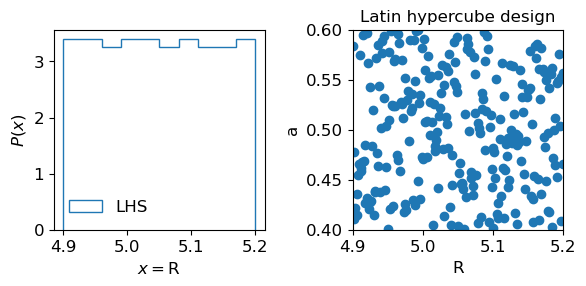

In [48]:
########## Block 4 ##########################
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Q1: Single and joint distribution
# Q2: difference between LHC and random design
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

# we have three subplots to check
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6,3))
# In subplot 1, check the one parameter distribution,
# and compare to the one generated in random design
ax1.hist(Design[0], bins=10, histtype='step', 
         density=True, label='LHS')
ax1.legend(loc='lower left')
ax1.set_xlabel(r"$x=$"+ParamTexLabels[0])
ax1.set_ylabel(r"$P(x)$")

# In subplot 2, check the two-parameter scatter plot
ax2.scatter(Design[0], Design[1])
ax2.axis([*ranges[0], *ranges[1]])
ax2.set_xlabel(ParamTexLabels[0])
ax2.set_ylabel(ParamTexLabels[1])
ax2.set_title("Latin hypercube design")

plt.tight_layout(True)

Load the calcualtion and compute observabeles:
1. Centrality is defined by $\sum E_T$ in the calculation.
2. The full distribution $P(\epsilon_n/\langle \epsilon_n \rangle)$ requires very high statistics. So instead, we will compare the width (std) and skewness of the distribution to experiments.

In [11]:
def load(f,limit=None):
    res = {}
    _, b, npart, ncoll, mult, e2, e3, e4, e5 = np.loadtxt(f, max_rows=limit).T
    index = np.argsort(mult)[::-1]
    res['b'] = b[index]
    res['npart'] = npart[index]
    res['mult'] = 4*mult[index]
    res['e2'] = e2[index]
    res['e3'] = e3[index]
    res['e4'] = e4[index]
    res['e5'] = e5[index]
    return res

def hist_w_err(y, range, bins):
    H, b = np.histogram(y, range=range, bins=bins)
    Norm = 1./len(y)/(b[1]-b[0])
    x = (b[1:]+b[:-1])/2.
    y = H * Norm
    yerr = np.sqrt(H)*Norm
    return x, y, yerr


def avg_w_err(y, cen, order=2):
    N = (len(y)*cen/100.).astype(int)
    x = (cen[1:] + cen[:-1])/2.
    Y = np.array([np.average(y[il:ih]**2) for il, ih in zip(N[:-1],N[1:])])
    Yerr = np.array([np.std(y[il:ih]**2)/np.sqrt(ih-il-1) for il, ih in zip(N[:-1],N[1:])])
    return x, Y**(1./order), 1/order*Y**(1./order-1.)*Yerr

def ComputeEn(i):
    print(i)
    cen = np.array([0,5,10,20,30,40,50,60,70,80])
    A = load("./res-all/{}.dat".format(i))
    x, mult, dmult = avg_w_err(A['mult'], cen)
    x, e2, de2 = avg_w_err(A['e2'], cen)
    x, e3, de3 = avg_w_err(A['e3'], cen)
    return np.concatenate([mult,e2, e3])

Obs = np.array([ComputeEn(i) for i in range(nsamples)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

First, plot the experimental data as a reference

[]

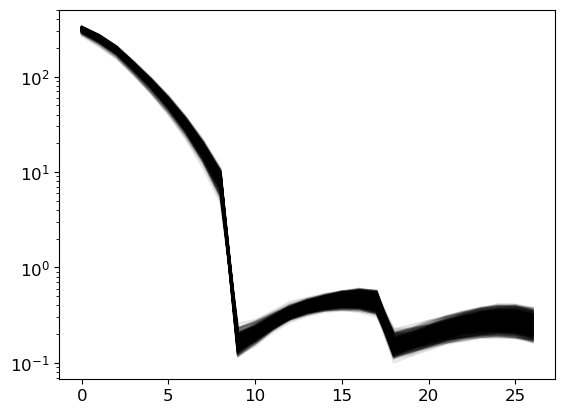

In [34]:
for i in range(512):
    plt.plot(Obs[i], alpha=0.1, color='k')
model_data = np.copy(Obs)
plt.semilogy()

In [35]:
########## Block 15 ##############
# This class take care most of the PCA functionalities that 
# we need in this example:
# 1. Transofrm design calculations into principal components
# model_data 100 x 36 --> PCs 100 x 36 --> 36 principal components
# 2. Selection of the first N=Npc dominant PCs
# PCs 100 x 36 --> 100 x Npc dominant PCs
# 3. Transfomation of prediction in the PC space 
#    back to the original observable space
# Npc PCs --> 36 obserbvables
# 4. Transofrmation of prediction covariance in the PC space
#    back to the original observable space
# Cov Npc x Npc (diagonal) --> Cov 36 x 36 --> prediction uncertainty
class Standardlization_PCA:
    def __init__(self, data, Npc):
        self.npc = Npc
        self.scaler = StandardScaler(copy=True)
        self.pca = PCA(copy=True, whiten=True, svd_solver='full')

        # Store the first Npc tranformed observables
        self.TransformedObs = self.pca.fit_transform(self.scaler.fit_transform(data))[:,:Npc]
        # Features of each PC
        self.Features = self.pca.components_
        # The transformation matrix from PC to Physical space
        self.TransformationMatrix = (np.sqrt(self.pca.explained_variance_[:Npc])\
                                    * self.pca.components_[:Npc,:].T).T \
                                    * self.scaler.scale_

        A = (np.sqrt(self.pca.explained_variance_[Npc:])\
            * self.pca.components_[Npc:,:].T).T \
            * self.scaler.scale_
        self.ResidualCov = np.dot(A.T*1., A)
        # cumulative sum of the explained variance
        self.CumulativeVariance = np.cumsum(self.pca.explained_variance_ratio_)
    def PC2Obs(self, PCs):
        return np.dot(PCs, self.TransformationMatrix) + self.scaler.mean_
    def PCcov2Obscov(self, PCcov, with_truncation_err=True):
        results = np.matmul(self.TransformationMatrix.T*PCcov, self.TransformationMatrix)
        if with_truncation_err:
            return results+self.ResidualCov
        else:
            return results
        

In [36]:
########## Block 16 ##############
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Q: How do you determine how many PCs should be used in analyais
#  Try to find out when you finish the rest of analysis, and then 
#  come back to this point to use a differnt number of PC
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Choose the number of principal components,
npc = 5
# And constuct the PCA transfromer
transformer = Standardlization_PCA(model_data, Npc=npc)

No handles with labels found to put in legend.


Linear correlation coefficients:  0.0


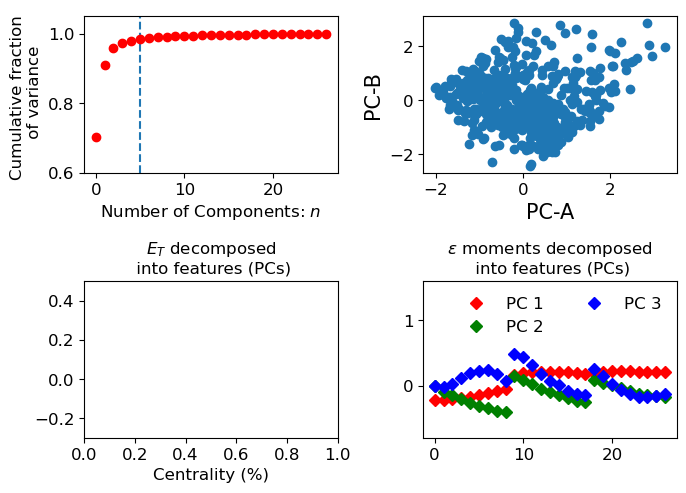

In [19]:
########## Block 17 ###########################
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Q1: Which PCs are important?
# Q2: What PCs look like?
# Q3: Are they linealy uncorrelated?
# Q4: Are their residue non-linear correlation?
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(7,5))

# Subplot 1: plot the cumulative variance contained in the first 
#            n principle components
ax1.plot(transformer.CumulativeVariance,'ro')
ax1.set_xlabel(r'Number of Components: $n$')
ax1.set_ylabel('Cumulative fraction \n of variance')
ax1.vlines(npc, .6, 1.2, linestyles='dashed')
ax1.set_ylim(.6,1.05)

# Subplot 2: plot the 2D scattered plot of any two PCs
#            Check the covariance between them, are they small?
#            Is there some non-linear structure in the plot?
Z1 = transformer.TransformedObs[:, 0]
Z2 = transformer.TransformedObs[:, 1]
ax2.scatter(Z1, Z2)
cov = np.cov(Z1, Z2)
print("Linear correlation coefficients: ", 
      cov[1,0]/np.sqrt(cov[0,0]*cov[1,1]))
ax2.set_xlabel('PC-A', fontsize=15)
ax2.set_ylabel('PC-B', fontsize=15)

# Subplot 3-4: plot the first few pinciple components
#              a new basis for parametrzing the D.o.F
#              present in the observables.
for i, (it, color) in \
        enumerate(zip(transformer.Features, 'rgb')):
    ax4.plot(it, 'D', color=color, label='PC {}'.format(i+1))
ax3.set_xlabel('Centrality (%)')
ax3.set_title(r"$E_T$ decomposed"+"\n into features (PCs)")
ax3.legend(ncol=2)
ax3.set_ylim(-.3, .5)
ax4.set_title(r"$\epsilon$ moments decomposed"+"\n into features (PCs)")
ax4.legend(ncol=2)
ax4.set_ylim(-.8,1.6)

plt.tight_layout(True)

In [20]:
########## Block 18 ##############
# Kernel function of Gaussion Process
# k(p1, p2) = C^2 * exp(-.5*(p1-p2)^2/L^2) + \delta(p1, p2)*level^2
# Range of hyper parameters:
# C: O(1)
# .1*(Pmax-Pmin) < L < 10*(Pmax-Pmin)
# 10^{-3} < NoiseLevel < 10^3
kernel = (
    1. * kernels.RBF(
        length_scale=[1.]*ptp,
        length_scale_bounds=np.outer(ptp, (.1, 10.))
    )  
    + kernels.WhiteKernel(
        noise_level=1., 
        noise_level_bounds=(1e-3, 1e3))
)

# Build and train each GP
gps = [ GPR(kernel=kernel, n_restarts_optimizer=4) 
        for i in range(npc) ]
for i, gp in enumerate(gps):
    gp.fit(Design.T, transformer.TransformedObs[:,i])
    print('RBF: ', gp.kernel_.get_params()['k1'])
    print('White: ', gp.kernel_.get_params()['k2'])

RBF:  4.77**2 * RBF(length_scale=[2, 1.32, 2.06, 4.54, 3, 2, 2.2, 1.39])
White:  WhiteKernel(noise_level=0.00903)
RBF:  2.22**2 * RBF(length_scale=[0.837, 0.678, 1.05, 10, 3, 0.75, 3, 3])
White:  WhiteKernel(noise_level=0.0511)
RBF:  3.92**2 * RBF(length_scale=[2, 0.712, 3.38, 2.28, 3, 0.722, 0.641, 0.689])
White:  WhiteKernel(noise_level=0.0635)
RBF:  3.31**2 * RBF(length_scale=[0.655, 0.937, 7.89, 2.43, 3, 0.508, 2.2, 0.614])
White:  WhiteKernel(noise_level=0.131)
RBF:  2.58**2 * RBF(length_scale=[1.32, 0.708, 3.81, 4.78, 3, 0.732, 0.395, 0.538])
White:  WhiteKernel(noise_level=0.136)


Q: The "optimized" hyper-parameters are listed above. Are they reasonable?

In [21]:
########## Block 19 ##############
# Making use of the Gaussian process you just trained,
# this function takes parameter point as input,
# and outputs predictions of model calcualtion using GPs
# as well as the prediction uncertainty (1 sigma)
def GP_pred_at_one_input(parameter, with_truncation_err=True):
    pcs, pcstd = np.array([gp.predict([parameter], return_std=True) for gp in gps]).T[0]
    pred = transformer.PC2Obs(pcs)
    pred_err = np.sqrt( np.diag( transformer.PCcov2Obscov(pcstd**2, with_truncation_err) ) )
    return pred, pred_err

### Step 3: Validating the Gaussian process

Q: how do you know these errorbars from Gaussian process are correctly reflecting the interpolation uncertainty?

## Step 6 Model-to-data comparison

### 6.1 Choose the ''experimental'' data

1. Pseudo-data : let us use one of the validation point as the pseudo data
2. Experimental data.

In [22]:
########## Block 22 ##############
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# First, let's use the validation data as a set
# of pseudodata to do a closure test:
# Closure test: use model calculation with known parameters
# as "experiments", and see if the Bayesian analysis is 
# able to infer the corrected values of the parameters.
# 
# Once you have tried validation set 0, 1, and 2,
# Come back to this point to use real data, by setting
# UsePseudoData = False
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
UsePseudoData = False
PseudoDataIdx = 0

In [23]:
########## Block 23 ##############
if UsePseudoData:
    pass
else:
    print("Using exp-data")
    _, y1 = np.loadtxt("../../exp/mult.dat").T
    cl, ch, c, y3, y2 = np.loadtxt("../../exp/data.dat").T
    yexp = np.concatenate([y1,y2,y3])
    ystat = .005*np.ones_like(yexp)

Using exp-data


In [25]:
ndim = 12
#double_ranges = np.concatenate([ranges, ranges])
double_ranges = np.array([
               [-0.1,0.1],
              [0.5,1.0],
               [0.3, 3.0],
                [0,1.0],
                    [4.9, 5.2],
                    [0.4, 0.6],
                    [0,.3],
                    [0,.3],
                    [4.9, 5.2],
                    [0.4, 0.6],
                    [0,.3],
                    [0,.3] ])

In [26]:


########## Block 24 ##############
from scipy.linalg import lapack
# calculate the log of Gaussian density with 
# residual dy = y-mu and covariance matrix cov.
# - 1/2 * dy^T * cov^[-1] * dy - 1/2*ln(|cov|)
def lnLL(dy, cov):
    L, info = lapack.dpotrf(cov, clean=False)
    alpha, info = lapack.dpotrs(L, dy)
    return -.5*np.dot(dy, alpha)-np.log(L.diagonal()).sum()

####### Step 5: Construct the posterior #################
def prior_ln_pdf(theta):
    if (theta<double_ranges[:,0]).any() or (theta>double_ranges[:,1]).any():
        return -np.inf
    else:
        return 0.

cov_exp = np.diag(ystat**2) 

def likelihood_ln_pdf(theta):
    # Ru
    pcs, pcstd = np.array([gp.predict([theta[:8]], return_std=True) for gp in gps]).T[0]
    pred1 = transformer.PC2Obs(pcs)
    cov_pred1 = transformer.PCcov2Obscov(pcstd**2, with_truncation_err=True)
    # Zr
    pcs, pcstd = np.array([gp.predict([np.concatenate([theta[:4],theta[8:]])], return_std=True) for gp in gps]).T[0]
    pred2 = transformer.PC2Obs(pcs)
    cov_pred2 = transformer.PCcov2Obscov(pcstd**2, with_truncation_err=True)
       
    ypred = pred1/pred2
    
    cov_pred = (cov_pred1/np.outer(pred1, pred1) + cov_pred2/np.outer(pred2, pred2)) * np.outer(ypred, ypred)
    
    dy = ypred-yexp
    cov = cov_exp + cov_pred
    return lnLL(dy[:-3], cov[:-3][:,:-3])

# Finally ln(Posterior) = ln(prior) + ln(likelihood)
def posterior_ln_pdf(theta):
    ln_pr = prior_ln_pdf(theta)
    ln_like = likelihood_ln_pdf(theta) 
    return ln_pr + ln_like

In [27]:
########## Block 25 ##############
def MCMC_generate(ranges, nsteps=1000, nburnin=200, ndim=8, nwalkers=10):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior_ln_pdf)
    # Burn in steps
    p0 = np.random.rand(nwalkers, ndim)
    p0 = (1.-p0)*ranges[:, 0] +  p0*ranges[:, 1]
    print("Burn-in stage")
    sampler.run_mcmc(p0, nburnin)
    # Production run
    p1 = sampler.chain[:,-1,:]
    print("Production stage")
    sampler.run_mcmc(p1, nsteps)
    print("Done")
    return sampler.chain.reshape((-1, ndim))

def Load_MCMC_chain(UsePseudoData, PseudoDataIdx, file='chain.h5'):
    with h5py.File(file, 'r') as f:
        if not UsePseudoData:
            samples = f['real-data'].value
        else:
            samples = f['validation-{:d}'.format(PseudoDataIdx)].value
    return samples

def Write_MCMC_chain(data, parameter_truth, UsePseudoData, PseudoDataIdx, file='chain.h5'):
    with h5py.File(file, 'a') as f:
        if not UsePseudoData:
            f.create_dataset("real-data", data=data, dtype=np.float)
        else:
            d = f.create_dataset('validation-{:d}'.format(PseudoDataIdx), data=data, dtype=np.float)
            d.attrs['truth'] = parameter_truth
    return samples

In [28]:
########## Block 26 ##############

# load pre-generated chain
#samples = Load_MCMC_chain(UsePseudoData, PseudoDataIdx)

# Generate your own chain, don't use this with the online Binder server, it is slow!
# Use it if you are using your own computer
samples = MCMC_generate(ranges=double_ranges, nsteps=2000, nburnin=1000, ndim=ndim, nwalkers=ndim*10)

Burn-in stage
Production stage
Done


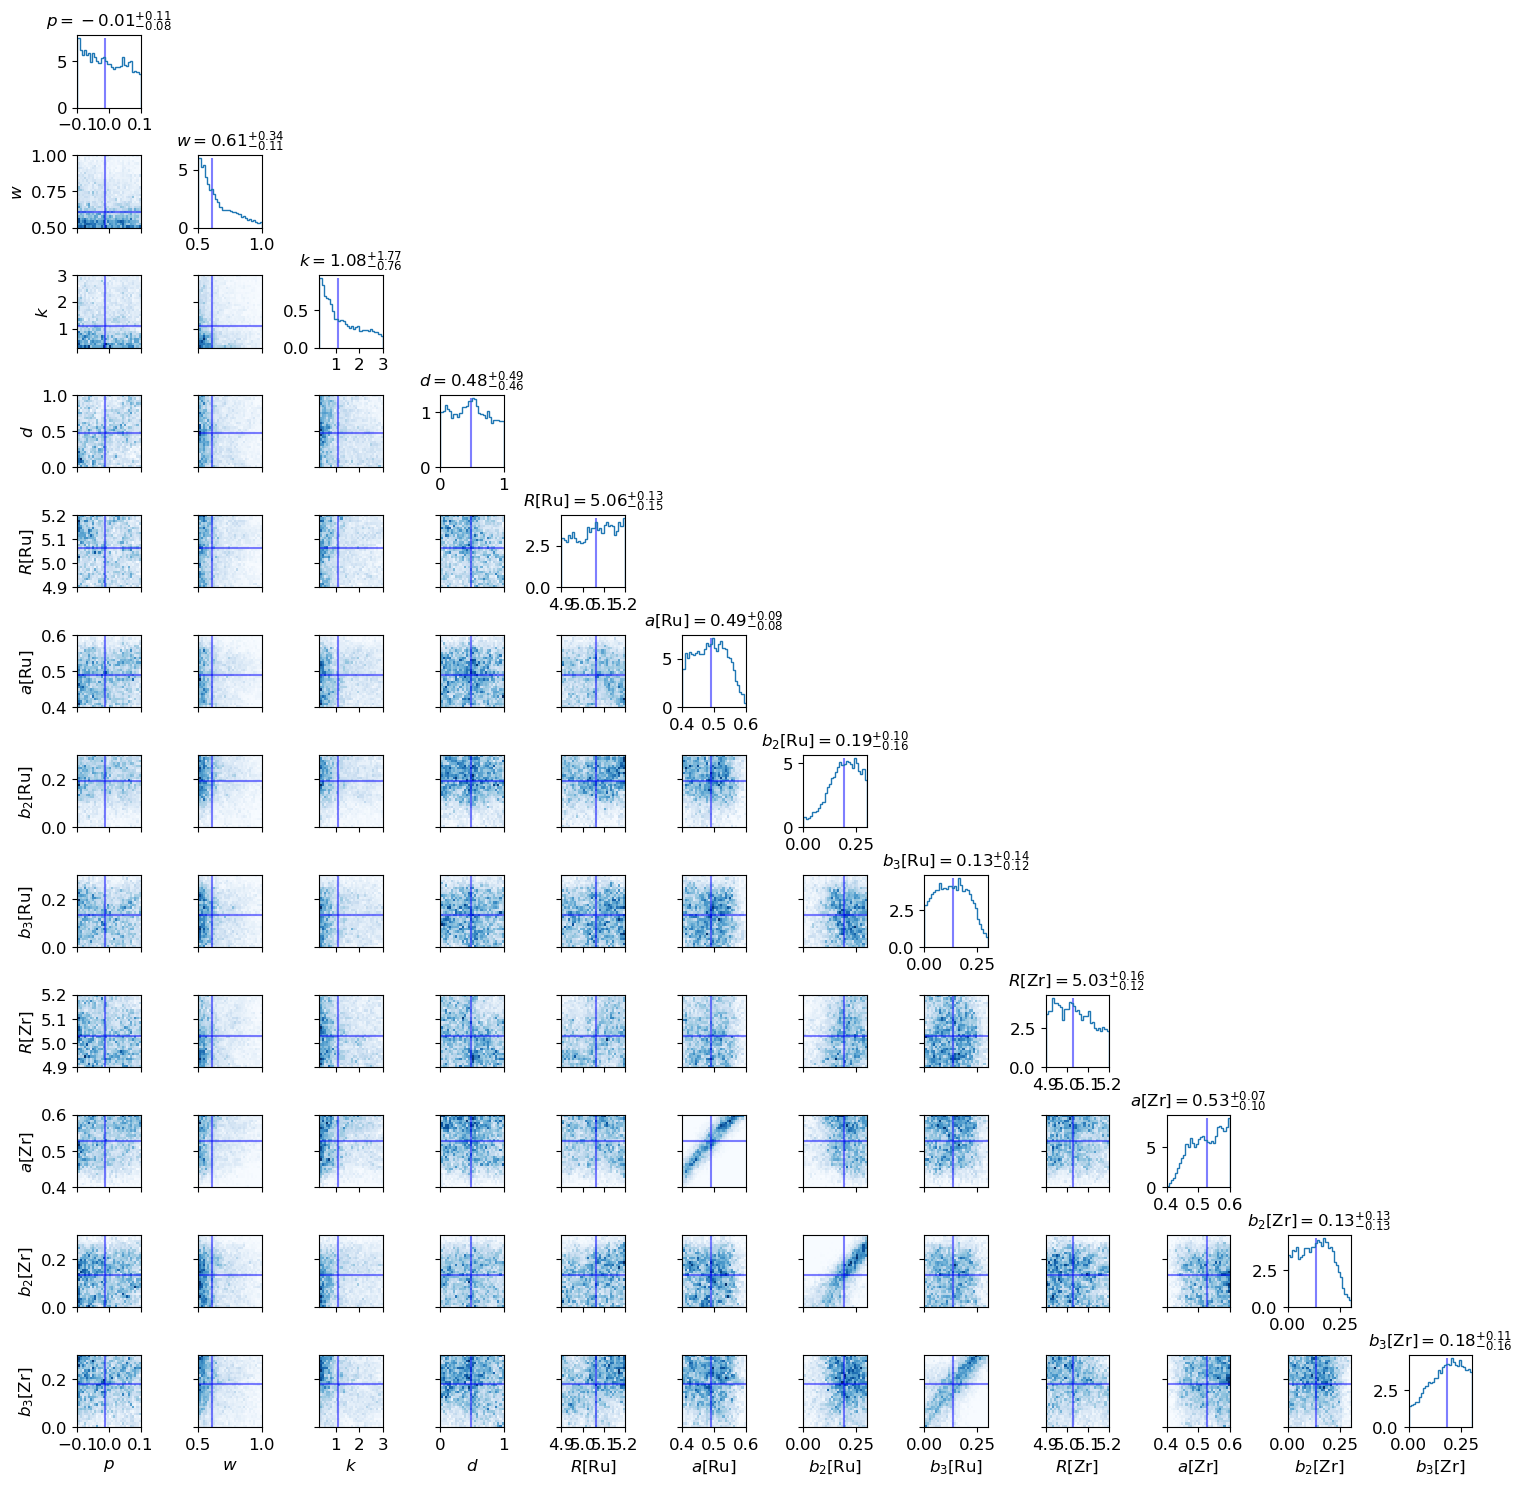

In [40]:
########## Block 27 ##############
#Write_MCMC_chain(samples, parameter_truth, UsePseudoData, PseudoDataIdx, file='chain.h5')
##### Step 7: Analyze the posterior distribution ########
# 1) Run this block and plot the posterior distribution
# 2) Does the posterior fairly estimates the true values (red)?
# 3) How does the posterior change it we take into account the
#    correlation among the sys-error?
figure, axes = plt.subplots(figsize=(15,15), 
                            ncols=ndim, nrows=ndim)
names = [r"$p$", "$w$", "$k$", "$d$",
         r"$R$[Ru]", "$a$[Ru]", "$b_2$[Ru]", "$b_3$[Ru]",
         r"$R$[Zr]", "$a$[Zr]", "$b_2$[Zr]", "$b_3$[Zr]"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            H, _,  _ = ax.hist(samples[:,i], bins=30,
                    range=double_ranges[i], histtype='step', 
                    density=True)
            if UsePseudoData:
                ax.vlines(parameter_truth[i],0,H.max(),color='r',alpha=0.5)
            xmedian = np.quantile(samples[:,i],.5)
            x2d5 = np.quantile(samples[:,i],.025)
            x97d5 = np.quantile(samples[:,i],.975)
            ax.vlines(xmedian,0,H.max(),color='b',alpha=0.5)
            ax.set_title(names[i]+r"$={:1.2f}_{{-{:1.2f}}}^{{+{:1.2f}}}$".format(xmedian,xmedian-x2d5,x97d5-xmedian))
            
            if ax.is_last_row():
                ax.set_xlabel(names[i])
            ax.set_xlim(*double_ranges[j])
        if i>j:
            ax.hist2d(samples[:, j], samples[:, i], 
                      bins=30, range=[double_ranges[j], double_ranges[i]], 
                      cmap='Blues')
            if UsePseudoData:
                ax.hlines(parameter_truth[i],*double_ranges[j],color='r',alpha=0.5)
                ax.vlines(parameter_truth[j],*double_ranges[i],color='r',alpha=0.5)
            ax.hlines(np.quantile(samples[:,i],.5),*double_ranges[j],color='b',alpha=0.5)
            ax.vlines(np.quantile(samples[:,j],.5),*double_ranges[i],color='b',alpha=0.5)
            if ax.is_last_row():
                ax.set_xlabel(names[j])
            else:
                ax.set_xticklabels([])
            if ax.is_first_col():
                ax.set_ylabel(names[i])
            else:
                ax.set_yticklabels([])
            ax.set_xlim(*double_ranges[j])
            ax.set_ylim(*double_ranges[i]) 
        if i<j:
            ax.axis('off')
plt.tight_layout(True)
#plt.savefig("corr-results.png")

In [32]:
########## Block 28 ##############
# predicting observables
param_samples = samples[np.random.choice(range(len(samples)),1000), :]
pred = np.array([
    GP_pred_at_one_input(theta[:8], with_truncation_err=True)[0]
  / GP_pred_at_one_input(np.concatenate([theta[:4],theta[8:]]), with_truncation_err=True)[0]
    for theta in param_samples
])



(1000, 27)


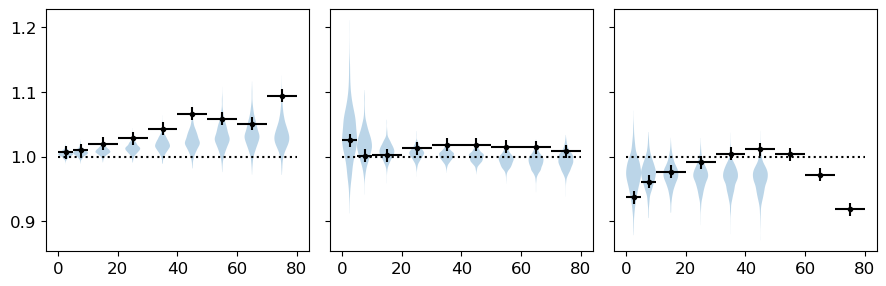

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize=(9,3), sharex=True, sharey=True)
print(pred.shape)
cen = [2.5,7.5,15,25,35,45,55,65,75]
ax1.violinplot(pred[:,:9], cen[:], widths=5, showextrema=False)
ax2.violinplot(pred[:,9:18], cen[:], widths=5, showextrema=False)
ax3.violinplot(pred[:,18:-3], cen[:-3], widths=5, showextrema=False)
cl,ch,c,y3,y2 = np.loadtxt("../../exp/data.dat").T
_,y1 = np.loadtxt("../../exp/mult.dat").T
ax1.errorbar(c,y1,fmt='k.',xerr=(ch-cl)/2., yerr=.01)
ax2.errorbar(c,y2,fmt='k.',xerr=(ch-cl)/2., yerr=.01)
ax3.errorbar(c,y3,fmt='k.',xerr=(ch-cl)/2., yerr=0.01)   
ax1.plot([0,80],[1,1],'k:')
ax2.plot([0,80],[1,1],'k:')
ax3.plot([0,80],[1,1],'k:')
plt.tight_layout(True)